# Punctuation tasks
In this tasks we have to predict commas in given sentences.

In [1]:
%reload_ext autoreload
%autoreload 2

from warnings import filterwarnings
filterwarnings('ignore')

# Part I. Data processing

In [2]:
from sberbank_baseline.data_processing import NgramManager
ngram_man = NgramManager()

In [3]:
from code_snippets.data_processing import get_sentences_from_text, sentance_to_windows, vectorizer
from code_snippets.utils import MyMorph

In [4]:
sentences = get_sentences_from_text('data/Dostoevskiyi_F._Idiot.txt', min_symbols_in_sent=10)
print(*sentences[:4], sep='\n\n')

часть первая

в конце ноября, в оттепель, часов в девять утра, поезд петербургско-варшавской железной дороги на всех парах подходил к петербургу

 было так сыро и туманно, что насилу рассвело; в десяти шагах, вправо и влево от дороги, трудно было разглядеть хоть что-нибудь из окон вагона

 из пассажиров были и возвращавшиеся из-за границы; но более были наполнены отделения для третьего класса, и всё людом мелким и деловым, не из очень далека


In [5]:
word_windows = []
for sentence in sentences:
    word_windows += sentance_to_windows(sentence, n_backw=5, n_frontw=5)
    
print(*word_windows[:4], sep='\n\n')

([], 'в', ['конце', 'ноября,', 'в', 'оттепель,', 'часов'])

(['в'], 'конце', ['ноября,', 'в', 'оттепель,', 'часов', 'в'])

(['в', 'конце'], 'ноября,', ['в', 'оттепель,', 'часов', 'в', 'девять'])

(['в', 'конце', 'ноября,'], 'в', ['оттепель,', 'часов', 'в', 'девять', 'утра,'])


In [6]:
import pandas as pd
morph = MyMorph()
X_df = pd.DataFrame([vectorizer(ww, morph, ngram_man) for ww in word_windows])

In [7]:
X_df.shape

(204388, 32)

In [8]:
# X_df.to_csv('data/X_df.csv', index=False)
X_df = pd.read_csv('data/X_df.csv')

In [9]:
X_df[['b_1_tag', 'f_1_tag', 'f_1_word', 'main_aspect', 'main_case', 'main_tag', 'main_word', 'y']].head(4)

,b_1_tag,f_1_tag,f_1_word,main_aspect,main_case,main_tag,main_word,y
0,NaN,NOUN,NaN,NaN,NaN,PREP,в,0
1,PREP,NOUN,NaN,NaN,loct,NOUN,NaN,0
2,NOUN,PREP,в,NaN,gent,NOUN,NaN,1
3,NOUN,NOUN,NaN,NaN,NaN,PREP,в,0


In [10]:
X_df = pd.get_dummies(X_df).fillna(0)

In [11]:
X_df.shape

(204388, 720)

In [12]:
X_df[[
    'b_1_tag_PREP', 'b_1_tag_NOUN', 'f_1_tag_PREP', 'f_1_tag_NOUN', 
    'f_1_word_в', 'main_word_в', 
    'y'
]].head(4)

,b_1_tag_PREP,b_1_tag_NOUN,f_1_tag_PREP,f_1_tag_NOUN,f_1_word_в,main_word_в,y
0,0,0,0,1,0,1,0
1,1,0,0,1,0,0,0
2,0,1,1,0,1,0,1
3,0,1,0,1,0,1,0


In [13]:
y = X_df.y
X_df.drop('y', axis=1, inplace=True)
X_df['weight'] = 1

Huge number of long complicated centences is good, but if we add task specified centences, we can get a better model. 

In [14]:
import pickle
with open('data/y_tasks', 'rb') as file:
    y_tasks = pickle.load(file)

with open('data/train_tasks', 'rb') as file:
    train_tasks = pickle.load(file)

In [15]:
# Add data in same format from tasks found in web with 5 times larger weight
X1_df = pd.DataFrame([vectorizer(ww, morph, ngram_man) for ww in train_tasks])
X1_df = pd.get_dummies(X1_df).fillna(0)
X1_df.drop('y', axis=1, inplace=True)
X1_df['weight'] = 5

In [16]:
X_df = X_df.append(X1_df).fillna(0)
y = pd.Series(list(y)+y_tasks)

In [17]:
y.value_counts()

0    175554
1     33055
dtype: int64

# Part II. Modelling

In [18]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.model_selection import StratifiedKFold

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.15)

W_train = X_train['weight']
X_train.drop('weight', axis=1, inplace=True)
W_test = X_test['weight']
X_test.drop('weight', axis=1, inplace=True)

In [20]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [21]:
X_train.shape

(177317, 757)

In [22]:
from sklearn.utils import class_weight
import numpy as np
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {k: v for k, v in enumerate(class_weights)}
class_weights

{0: 0.5940705847667165, 1: 3.1575788873851414}

In [23]:
# building a model with keras
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
from keras.callbacks import ProgbarLogger
from keras import backend as K 

K.clear_session()
model = Sequential()  

model.add(Dense(60, input_shape=(X_train.shape[1],), init = 'uniform')) 
model.add(Dropout(.5))

model.add(Dense(20, init = 'uniform'))
model.add(Dropout(.1))
model.add(Activation('relu'))

model.add(Dense(1, init = 'uniform'))
model.add(Activation('sigmoid'))

Using TensorFlow backend.


In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 60)                45480     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1220      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                

In [25]:
from keras.callbacks import Callback, EarlyStopping
my_callbacks = [EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='min')]

model.compile(
    loss='binary_crossentropy', 
    optimizer='adam',
    metrics=['accuracy']
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [26]:
history = model.fit(
    X_train, 
    y_train,
    batch_size=256, 
    epochs=100,
    validation_data=(X_test, y_test, W_test.values),
    verbose=2,
    class_weight=class_weights,
    callbacks=my_callbacks,
    sample_weight=W_train.values
)


Train on 177317 samples, validate on 31292 samples
Epoch 1/100
 - 15s - loss: 0.5794 - accuracy: 0.6758 - val_loss: 0.5138 - val_accuracy: 0.7688
Epoch 2/100
 - 15s - loss: 0.5163 - accuracy: 0.7613 - val_loss: 0.5088 - val_accuracy: 0.7711
Epoch 3/100
 - 16s - loss: 0.5063 - accuracy: 0.7663 - val_loss: 0.5034 - val_accuracy: 0.7726
Epoch 4/100
 - 17s - loss: 0.5001 - accuracy: 0.7709 - val_loss: 0.5129 - val_accuracy: 0.7684
Epoch 5/100
 - 15s - loss: 0.4969 - accuracy: 0.7706 - val_loss: 0.4930 - val_accuracy: 0.7827
Epoch 6/100
 - 550s - loss: 0.4923 - accuracy: 0.7753 - val_loss: 0.5117 - val_accuracy: 0.7764
Epoch 7/100
 - 27s - loss: 0.4883 - accuracy: 0.7753 - val_loss: 0.5011 - val_accuracy: 0.7830
Epoch 8/100
 - 16s - loss: 0.4850 - accuracy: 0.7771 - val_loss: 0.5143 - val_accuracy: 0.7763
Epoch 9/100
 - 11s - loss: 0.4789 - accuracy: 0.7798 - val_loss: 0.4931 - val_accuracy: 0.7811
Epoch 10/100
 - 11s - loss: 0.4760 - accuracy: 0.7755 - val_loss: 0.4876 - val_accuracy: 0.7

Train: 0.792, Test: 0.788


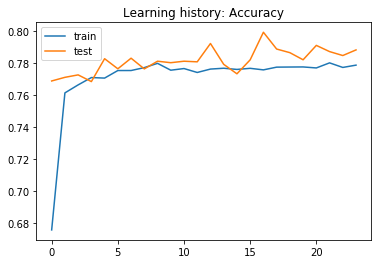

Train: 0.792, Test: 0.788


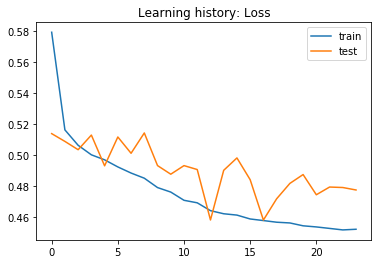

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.title('Learning history: Accuracy')
plt.show()

import matplotlib.pyplot as plt
%matplotlib inline
# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('Learning history: Loss')
plt.show()